# Summary

I'm working with a database of 1.88 million geo-referenced wildfire records that occured in the United States from 1992 to 2015, representing a total of 140 million acres burned during the 24-year period. After some exploratory analysis, I have eliminated unhelpful or unavailable columns for predicting the final size of a wildfire at the time of its discovery. 

# Table of Contents
1. [Load SQLite Database](#load_data) 
2. [Created subset](#subset)
3. [Exploratory Data Analysis](#eda)  
    3.1. [Target Variable](#target)  
    3.2. [All Features](#all_features)  
    3.3. [Date and Time Features](#date_time)  
    3.4. [Fire Cause](#cause)  
    3.5. [Location Features](#location)  
4. [Clean Up](#cleanup)  
5. [Next Steps](#next_steps)

# Imports

In [1]:
import pandas as pd
pd.set_option('display.max_columns',500) # avoid truncation

import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import sqlite3 

<a id="load_data"></a>
# 1. Load SQLite database


### Source:  
#### US wildfires dataset can be downloaded from https://www.kaggle.com/rtatman/188-million-us-wildfires/home

"This data publication contains a spatial database of wildfires that occurred in the United States from 1992 to 2015. It is the third update of a publication originally generated to support the national Fire Program Analysis (FPA) system. The wildfire records were acquired from the reporting systems of federal, state, and local fire organizations. The following core data elements were required for records to be included in this data publication: discovery date, final fire size, and a point location at least as precise as Public Land Survey System (PLSS) section (1-square mile grid). The data were transformed to conform, when possible, to the data standards of the National Wildfire Coordinating Group (NWCG). Basic error-checking was performed and redundant records were identified and removed, to the degree possible. The resulting product, referred to as the Fire Program Analysis fire-occurrence database (FPA FOD), includes 1.88 million geo-referenced wildfire records, representing a total of 140 million acres burned during the 24-year period."

In [2]:
# Load into pandas since it's only one table
# alternatively, explore with SQL 
conn = sqlite3.connect("FPA_FOD_20170508.sqlite") 
fires = pd.read_sql_query("SELECT * FROM fires ", conn)

In [3]:
len(fires)

1880465

In [4]:
fires.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,FIRE_CODE,FIRE_NAME,ICS_209_INCIDENT_NUMBER,ICS_209_NAME,MTBS_ID,MTBS_FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,1,PNF-47,BJ8K,FOUNTAIN,None,None,None,None,None,2005,2453403.5,33,1300,9.0,Miscellaneous,2453403.5,33.0,1730,0.10,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,13,13,AAC0,PIGEON,None,None,None,None,None,2004,2453137.5,133,0845,1.0,Lightning,2453137.5,133.0,1530,0.25,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,27,021,A32W,SLACK,None,None,None,None,None,2004,2453156.5,152,1921,5.0,Debris Burning,2453156.5,152.0,2024,0.10,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,43,6,None,DEER,None,None,None,None,None,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1400,0.10,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,44,7,None,STEVENOT,None,None,None,None,None,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1200,0.10,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


<a id="subset"></a>

# 2. Create subset to do EDA

Explore with 50k rows

In [5]:
fires_sam = fires.sample(50000) 

In [6]:
with open('raw_fire_subset.pkl', 'wb') as picklefile:
    pickle.dump(fires_sam, picklefile)

<a id="eda"></a>
# 3. Exploratory Data Analysis with subset


In [7]:
#Load data
with open('raw_fire_subset.pkl', 'rb') as picklefile:
    fires = pickle.load(picklefile)

In [8]:
fires.shape

(50000, 39)

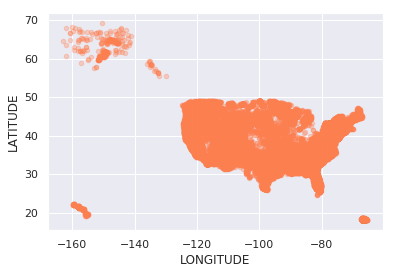

In [9]:
#https://www.kaggle.com/edhirif/predict-the-causes-of-wildfires-using-python
#Paul ONeill
# fun use of coordinates 
fires.plot(kind='scatter',x='LONGITUDE',y='LATITUDE',color='coral',alpha=0.3)

In [10]:
# columns available 
fires.columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape'],
      dtype='object')

In [11]:
fires.nunique()

OBJECTID                      50000
FOD_ID                        50000
FPA_ID                        50000
SOURCE_SYSTEM_TYPE                3
SOURCE_SYSTEM                    37
NWCG_REPORTING_AGENCY             9
NWCG_REPORTING_UNIT_ID          818
NWCG_REPORTING_UNIT_NAME        817
SOURCE_REPORTING_UNIT          2142
SOURCE_REPORTING_UNIT_NAME     1969
LOCAL_FIRE_REPORT_ID           1271
LOCAL_INCIDENT_ID             21652
FIRE_CODE                      6199
FIRE_NAME                     20541
ICS_209_INCIDENT_NUMBER         684
ICS_209_NAME                    681
MTBS_ID                         283
MTBS_FIRE_NAME                  263
COMPLEX_NAME                    117
FIRE_YEAR                        24
DISCOVERY_DATE                 8189
DISCOVERY_DOY                   366
DISCOVERY_TIME                 1314
STAT_CAUSE_CODE                  13
STAT_CAUSE_DESCR                 13
CONT_DATE                      7097
CONT_DOY                        366
CONT_TIME                   

In [12]:
fires[['OBJECTID', 'FOD_ID', 'FPA_ID']].head()
# 3 ID's are unique 
# Keep only FOD_ID as primary key "Fire Occurence database"
# because from the uploader: FOD_ID = Global unique identifier.

,OBJECTID,FOD_ID,FPA_ID
334821,334822,343186,W-104374
1674798,1674799,201838989,SFO-2013ALAFC049343
1692175,1692176,201862585,TFS-TXFD2013-471787
1135865,1135866,1385051,CDF_2008_55_2225_067524
130533,130534,131832,FS-357214


In [13]:
cols_to_drop = []
cols_to_drop.extend(['OBJECTID', 'FPA_ID'])

<a id="target"></a>
# 3.1 Target Variable

How big will a wildfire get?

FIRE_SIZE_CLASS = Code for fire size based on the number of acres within the final fire perimeter expenditures (A=greater than 0 but less than or equal to 0.25 acres, B=0.26-9.9 acres, C=10.0-99.9 acres, D=100-299 acres, E=300 to 999 acres, F=1000 to 4999 acres, and G=5000+ acres).

In [14]:
fires['FIRE_SIZE_CLASS'].value_counts().sort_index()
# Classes are very imbalanced. Over 80% of fires less than 10 acres.

A    17694
B    24939
C     5913
D      777
E      375
F      206
G       96
Name: FIRE_SIZE_CLASS, dtype: int64

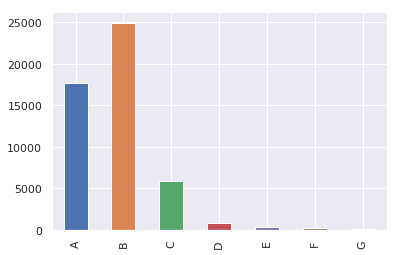

In [15]:
fires['FIRE_SIZE_CLASS'].value_counts().sort_index().plot(kind='bar')

FIRE_SIZE = Estimate of acres within the final perimeter of the fire.

In [16]:
fires['FIRE_SIZE'].describe()
# as small as 1/10000 of an acre

count     50000.000000
mean         86.714228
std        3445.608964
min           0.001000
25%           0.100000
50%           1.000000
75%           3.202500
max      461047.000000
Name: FIRE_SIZE, dtype: float64

<a id="all_features"></a>
# 3.2 All Features



In [17]:
# Get a sense of the number of nulls in each column
fires.count()

OBJECTID                      50000
FOD_ID                        50000
FPA_ID                        50000
SOURCE_SYSTEM_TYPE            50000
SOURCE_SYSTEM                 50000
NWCG_REPORTING_AGENCY         50000
NWCG_REPORTING_UNIT_ID        50000
NWCG_REPORTING_UNIT_NAME      50000
SOURCE_REPORTING_UNIT         50000
SOURCE_REPORTING_UNIT_NAME    50000
LOCAL_FIRE_REPORT_ID          10969
LOCAL_INCIDENT_ID             28291
FIRE_CODE                      8440
FIRE_NAME                     24349
ICS_209_INCIDENT_NUMBER         690
ICS_209_NAME                    690
MTBS_ID                         283
MTBS_FIRE_NAME                  283
COMPLEX_NAME                    125
FIRE_YEAR                     50000
DISCOVERY_DATE                50000
DISCOVERY_DOY                 50000
DISCOVERY_TIME                26294
STAT_CAUSE_CODE               50000
STAT_CAUSE_DESCR              50000
CONT_DATE                     26047
CONT_DOY                      26047
CONT_TIME                   

In [18]:
# Check out the reporting agency information
fires.iloc[:,3:18].head()

,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,FIRE_CODE,FIRE_NAME,ICS_209_INCIDENT_NUMBER,ICS_209_NAME,MTBS_ID,MTBS_FIRE_NAME
334821,FED,DOI-WFMI,BLM,USNVELD,Ely District Office,NVELD,Ely District Office,None,None,K268,WILLOW CR,None,None,None,None
1674798,NONFED,ST-NASF,ST/C&L,USALALS,Alabama Forestry Commission,ALAFC,Alabama Forestry Commission,None,049343,None,NWR-20130514-001,None,None,None,None
1692175,NONFED,ST-TXTXS,ST/C&L,USTXTXS,Texas A & M Forest Service,TXSFD,Mexia Fire Department,None,471787,None,FM 1365 & LCR 490,None,None,None,None
1135865,NONFED,ST-CACDF,ST/C&L,USCARRU,Riverside Unit,CARRU,CDF - Riverside Unit,None,067524,None,MESQUITE AV / HACIENDA AV,None,None,None,None
130533,FED,FS-FIRESTAT,FS,USCASTF,Stanislaus National Forest,0516,Stanislaus National Forest,17,None,7500,QUILTY I,None,None,None,None


In [19]:
fires.groupby('SOURCE_SYSTEM_TYPE')['FIRE_SIZE_CLASS'].value_counts()

SOURCE_SYSTEM_TYPE  FIRE_SIZE_CLASS
FED                 A                   6539
                    B                   4312
                    C                    992
                    D                    269
                    E                    171
                    F                    137
                    G                     74
INTERAGCY           B                    555
                    A                    277
                    C                    105
                    D                     25
                    E                     24
                    F                     16
                    G                      6
NONFED              B                  20072
                    A                  10878
                    C                   4816
                    D                    483
                    E                    180
                    F                     53
                    G                     16
Name: FIRE_SIZE_CLA

In [20]:
# Type of source database or system that the record was drawn from (federal, nonfederal, or interagency
# If a fire is big, it tends to get into the federal database. Not useful for prediction
cols_to_drop.append('SOURCE_SYSTEM_TYPE')
# And other "reporting" columns are the specific agencies preparing the fire report
# and local identification numbers
cols_to_drop.extend(['SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE'])

FIRE_CODE = Code used within the interagency wildland fire community to track and compile cost information for emergency fire suppression (https://www.firecode.gov/).  
Seems like an interesting column but the fire code system is designed for use by Federal land management agencies and use by the public is restricted. Also, a lot of missing values. 

In [21]:
# big fires get names, as you'd expect
# Monitoring Trends in Burn Severity (MTBS): only tracks big fires
fires[fires['MTBS_FIRE_NAME'].notnull()]['FIRE_SIZE_CLASS'].value_counts()


F    150
G     92
E     39
D      1
C      1
Name: FIRE_SIZE_CLASS, dtype: int64

In [22]:
# names won't be useful for predicting 
cols_to_drop.extend(['FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME'])

In [23]:
fires[['OWNER_CODE', 'OWNER_DESCR', 'Shape']].head()

,OWNER_CODE,OWNER_DESCR,Shape
334821,1.0,BLM,b'\x00\x01\xad\x10\x00\x00\xac\x94e\x88c\xb5\\...
1674798,14.0,MISSING/NOT SPECIFIED,b'\x00\x01\xad\x10\x00\x00\x1c\x8bmR\xd1\xd3U\...
1692175,8.0,PRIVATE,b'\x00\x01\xad\x10\x00\x00\xdc4}v\xc0\x1cX\xc0...
1135865,14.0,MISSING/NOT SPECIFIED,b'\x00\x01\xad\x10\x00\x00\xa8n\r\xf0\xcd\x1f]...
130533,13.0,STATE OR PRIVATE,b'\x00\x01\xad\x10\x00\x00\x94\xad\xbb\x9ax\x0...


In [24]:
# Owner info too specific
# Shape will be at the end - useful for a different question
cols_to_drop.extend(['OWNER_CODE', 'OWNER_DESCR', 'Shape'])


<a id="date_time"></a>
# 3.3 Date and Time Features



Text(0.5,1,'Fire occurences by year on subset')

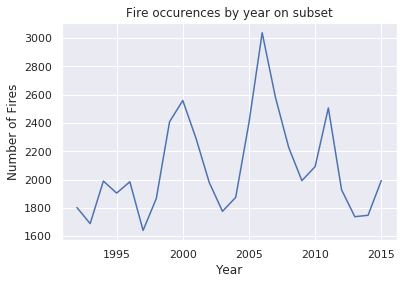

In [25]:
fires['FIRE_YEAR'].value_counts().sort_index().plot()
plt.xlabel('Year')
plt.ylabel('Number of Fires')
plt.title('Fire occurences by year on subset')
# ***NOTE*** # check the distribution for full dataset
# Are fires getting more common?
# Are big fires getting more common? 
# Acres burned per year?


#### Check out contained date
Won't be an avaiable column to predict with but good to explore

In [26]:
%time fires['days_to_contain'] = fires['CONT_DATE'] - fires['DISCOVERY_DATE']

CPU times: user 9 ms, sys: 4.8 ms, total: 13.8 ms
Wall time: 2.72 s


In [27]:
fires['days_to_contain'].head()

334821     3.0
1674798    0.0
1692175    NaN
1135865    NaN
130533     1.0
Name: days_to_contain, dtype: float64

In [28]:
# the DATE columns are in julian dates but the unit is day so difference works
# quick demo 
tst = fires[['DISCOVERY_DATE', 'CONT_DATE']].head()
tst['disc_date'] = pd.to_datetime(tst['DISCOVERY_DATE'], origin='julian', unit='D')
tst['cont_date'] = pd.to_datetime(tst['CONT_DATE'], origin='julian', unit='D')
tst

,DISCOVERY_DATE,CONT_DATE,disc_date,cont_date
334821,2452135.5,2452138.5,2001-08-14,2001-08-17
1674798,2456426.5,2456426.5,2013-05-14,2013-05-14
1692175,2456540.5,NaN,2013-09-05,NaT
1135865,2454679.5,NaN,2008-08-01,NaT
130533,2451723.5,2451724.5,2000-06-28,2000-06-29


In [29]:
fires.groupby('FIRE_SIZE_CLASS')['days_to_contain'].describe()

# There are some outliers but a trend emerges that big fires take longer to contain.


,count,mean,std,min,25%,50%,75%,max
FIRE_SIZE_CLASS,,,,,,,,
A,11043.0,1.068188,9.648419,0.0,0.0,0.0,0.0,374.0
B,11334.0,0.711399,7.724641,0.0,0.0,0.0,0.0,366.0
C,2755.0,1.112160,6.336209,0.0,0.0,0.0,0.0,106.0
D,437.0,3.915332,11.703511,0.0,0.0,1.0,2.0,95.0
E,243.0,9.008230,28.181817,0.0,0.0,1.0,5.0,371.0
F,151.0,12.682119,23.589651,0.0,1.0,4.0,10.0,165.0
G,84.0,31.773810,36.498342,0.0,5.0,11.0,60.5,143.0


Text(0,0.5,'Fire size class')

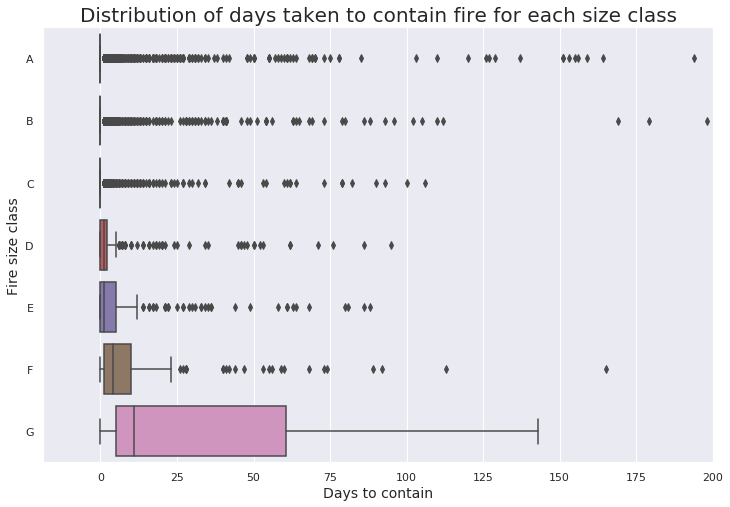

In [30]:
# boxplot shows this trend better
# a lot of outliers for the smaller classes but looking at the 3rd quartile shows a clear trend
plt.figure(figsize=(12,8))
sns.boxplot(x='days_to_contain', y='FIRE_SIZE_CLASS', data=fires, order=['A', 'B', 'C', 'D', 'E', 'F', 'G'])
plt.title('Distribution of days taken to contain fire for each size class', fontsize=20)
plt.xlim(right= 200)
plt.xlabel('Days to contain', fontsize=14)
plt.ylabel('Fire size class', fontsize=14)


In [31]:
# Looking at specific outliers
fires[(fires['FIRE_SIZE_CLASS'] == 'A') & (fires['days_to_contain'] > 200)]

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,FIRE_CODE,FIRE_NAME,ICS_209_INCIDENT_NUMBER,ICS_209_NAME,MTBS_ID,MTBS_FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape,days_to_contain
1739194,1739195,300077000,SFO-2014NY5262NY5262-2014-93,NONFED,ST-NASF,ST/C&L,USNYNYX,Fire Department of New York,NY5262,Fire Department of New York,None,NY5262-2014-93,None,None,None,None,None,None,None,2014,2456724.5,67,None,1.0,Lightning,2456986.5,329.0,None,0.10,A,40.8262,-72.7731,14.0,MISSING/NOT SPECIFIED,NY,SUFFOLK,103,Suffolk,"b'\x00\x01\xad\x10\x00\x00d""lxz1R\xc0H\xfa\xed...",262.0
1782758,1782759,300138799,SFO-2014NY4211NY4211-2014-6595,NONFED,ST-NASF,ST/C&L,USNYNYX,Fire Department of New York,NY4211,Fire Department of New York,None,NY4211-2014-6595,None,None,None,None,None,None,None,2014,2456803.5,146,1807,9.0,Miscellaneous,2457018.5,361.0,1844,0.10,A,42.5820,-73.7042,14.0,MISSING/NOT SPECIFIED,NY,RENSSELAER,083,Rensselaer,b'\x00\x01\xad\x10\x00\x00\xf4u\xe0\x9c\x11mR\...,215.0
1782231,1782232,300137964,SFO-2014NY2401NY2401-2014-241068,NONFED,ST-NASF,ST/C&L,USNYNYX,Fire Department of New York,NY2401,Fire Department of New York,None,NY2401-2014-241068,None,None,None,None,None,None,None,2014,2456733.5,76,1557,9.0,Miscellaneous,2456984.5,327.0,1728,0.10,A,40.7366,-73.8011,14.0,MISSING/NOT SPECIFIED,NY,QUEENS,081,Queens,b'\x00\x01\xad\x10\x00\x00\xd44\xef8EsR\xc0\xf...,251.0
1745304,1745305,300085194,SFO-2014NY1301NY1301-2014-114,NONFED,ST-NASF,ST/C&L,USNYNYX,Fire Department of New York,NY1301,Fire Department of New York,None,NY1301-2014-114,None,None,None,None,None,None,None,2014,2456658.5,1,2115,3.0,Smoking,2456880.5,223.0,2133,0.10,A,42.1788,-74.7202,14.0,MISSING/NOT SPECIFIED,NY,DELAWARE,025,Delaware,b'\x00\x01\xad\x10\x00\x00\x10\xa5\xbd\xc1\x17...,222.0
1739206,1739207,300077015,SFO-2014WADNR309,NONFED,ST-NASF,ST/C&L,USWAWAS,Washington State Headquarters,WADNR,Washington Department of Natural Resources,None,309,None,GOLDEN HIKE,638842,CARLTON COMPLEX,None,None,CARLTON COMPLEX,2014,2456852.5,195,1200,1.0,Lightning,2457063.5,41.0,1200,0.01,A,48.1968,-120.1276,7.0,STATE,WA,047,047,Okanogan,b'\x00\x01\xad\x10\x00\x00\x0c\xbe0\x99*\x08^\...,211.0
1781991,1781992,300137609,SFO-2014NY2401NY2401-2014-309847,NONFED,ST-NASF,ST/C&L,USNYNYX,Fire Department of New York,NY2401,Fire Department of New York,None,NY2401-2014-309847,None,None,None,None,None,None,None,2014,2456754.5,97,1455,9.0,Miscellaneous,2456974.5,317.0,1512,0.10,A,40.6280,-73.9163,14.0,MISSING/NOT SPECIFIED,NY,KINGS,047,Kings,b'\x00\x01\xad\x10\x00\x00\xc8T\xc1\xa8\xa4zR\...,220.0
298607,298608,304203,W-433141,FED,DOI-WFMI,BIA,USAZFYA,Fort Yuma Agency,AZFYA,Fort Yuma Agency,2,None,AZ4U,AVENUE,None,None,None,None,None,2004,2453027.5,23,0800,9.0,Miscellaneous,2453401.5,31.0,1600,0.10,A,32.7303,-114.6250,2.0,BIA,CA,None,None,None,b'\x00\x01\xad\x10\x00\x00\xfc\xff\xff\xff\xff...,374.0
1782240,1782241,300137973,SFO-2014NY5208NY5208-2014-428,NONFED,ST-NASF,ST/C&L,USNYNYX,Fire Department of New York,NY5208,Fire Department of New York,None,NY5208-2014-428,None,None,None,None,None,None,None,2014,2456775.5,118,1704,9.0,Miscellaneous,2456985.5,328.0,1726,0.10,A,40.7770,-73.1230,14.0,MISSING/NOT SPECIFIED,NY,SUFFOLK,103,Suffolk,b'\x00\x01\xad\x10\x00\x00\x18Zd;\xdfGR\xc0\x0...,210.0
1781664,1781665,300137148,SFO-2014NY2401NY2401-2014-292839,NONFED,ST-NASF,ST/C&L,USNYNYX,Fire Department of New York,NY2401,Fire Department of New York,None,NY2401-2014-292839,None,None,None,None,None,None,None,2014,2456750.5,93,1738,9.0,Miscellaneous,2456963.5,306.0,1800,0.10,A,40.6754,-73.9082,14.0,MISSING/NOT SPECIFIED,NY,KINGS,047,Kings,b'\x00\x01\xad\x1

In [32]:
fires[(fires['FIRE_SIZE_CLASS'] == 'E') & (fires['days_to_contain'] > 200)]

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,FIRE_CODE,FIRE_NAME,ICS_209_INCIDENT_NUMBER,ICS_209_NAME,MTBS_ID,MTBS_FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape,days_to_contain
1286202,1286203,1756765,SFO-WY-2010-8166,NONFED,ST-NASF,ST/C&L,USWYWYS,Wyoming State Forestry,WYWSFD,Wyoming State Forestry,None,8166,None,None,None,None,None,None,None,2010,2455427.5,231,1315,1.0,Lightning,2455798.5,237.0,None,453.0,E,43.25473,-105.20273,8.0,PRIVATE,WY,Campbell,005,Campbell,b'\x00\x01\xad\x10\x00\x00\xc0\xfa?\x87\xf9LZ\...,371.0


In [33]:
cols_to_drop.extend(['CONT_DATE', 'CONT_DOY','CONT_TIME','days_to_contain'])

In [34]:
%time fires['hr'] = (fires['DISCOVERY_TIME'].astype('float64')) // 100

CPU times: user 5.24 ms, sys: 110 µs, total: 5.35 ms
Wall time: 5.17 ms


In [35]:
fires.pivot_table(values='FOD_ID', index='hr', columns='FIRE_SIZE_CLASS',
                 aggfunc=lambda x: x.nunique())
# time of day can have potential but over 50% missing and no logical way to fill in
# can keep 'hr' for now and see if it provides any signal

FIRE_SIZE_CLASS,A,B,C,D,E,F,G
hr,,,,,,,
0.0,102.0,91.0,21.0,4.0,2.0,2.0,NaN
1.0,81.0,49.0,18.0,4.0,NaN,2.0,NaN
2.0,51.0,52.0,8.0,3.0,1.0,1.0,NaN
3.0,56.0,48.0,8.0,1.0,1.0,NaN,1.0
4.0,46.0,45.0,17.0,NaN,1.0,1.0,1.0
5.0,53.0,51.0,9.0,3.0,1.0,NaN,NaN
6.0,108.0,75.0,18.0,2.0,1.0,1.0,1.0
7.0,181.0,108.0,26.0,2.0,NaN,3.0,1.0
8.0,294.0,148.0,41.0,5.0,6.0,4.0,5.0


In [36]:
# DISCOVERY_TIME has potential but over half is missing
# DOY doesn't make sense to use as a feature - extract month from DATE
cols_to_drop.extend(['DISCOVERY_TIME', 'DISCOVERY_DOY'])

<a id="cause"> </a>
# 3.4 Cause
Another column to explore but likely unsure at time of discovery



In [37]:
fires.groupby('STAT_CAUSE_DESCR')['FOD_ID'].count() 
#remove - unlikely to know at time of discovery

STAT_CAUSE_DESCR
Arson                 7573
Campfire              1944
Children              1625
Debris Burning       11386
Equipment Use         3856
Fireworks              309
Lightning             7421
Miscellaneous         8636
Missing/Undefined     4471
Powerline              380
Railroad               865
Smoking               1426
Structure              108
Name: FOD_ID, dtype: int64

In [38]:
def set_label(cat):
    '''Consolidate causes into 4 categories'''
    cause = 0
    Lightning = ['Lightning']
    accidental = ['Structure','Fireworks','Powerline','Railroad','Smoking','Children','Campfire','Equipment Use','Debris Burning']
    malicious = ['Arson']
    other = ['Missing/Undefined','Miscellaneous']
    if cat in Lightning: 
        cause = 'Lightning'
    elif cat in accidental: 
        cause = 'Accident'
    elif cat in malicious:  
        cause = 'Arson'
    else:
        cause = 'Other'
    return cause
     

In [39]:
%time fires['Cause'] = fires['STAT_CAUSE_DESCR'].apply(lambda x:set_label(x))

CPU times: user 27.8 ms, sys: 0 ns, total: 27.8 ms
Wall time: 27.6 ms


In [40]:
cols_to_drop.extend(['STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR'])

In [41]:
fires.groupby('Cause')['FOD_ID'].count() 

Cause
Accident     21899
Arson         7573
Lightning     7421
Other        13107
Name: FOD_ID, dtype: int64

In [42]:
fires.pivot_table(values='FOD_ID', index='FIRE_SIZE_CLASS', columns='Cause',
                 aggfunc='count', margins=True)
# Lightning causes almost half of big (F and G) fires. A proxy for lightning may be useful

Cause,Accident,Arson,Lightning,Other,All
FIRE_SIZE_CLASS,,,,,
A,7101,1658,3986,4949,17694
B,12129,4101,2321,6388,24939
C,2299,1547,676,1391,5913
D,228,185,164,200,777
E,90,54,125,106,375
F,38,27,86,55,206
G,14,1,63,18,96
All,21899,7573,7421,13107,50000


<a id="location"></a>
# 3.5 Location


LATITUDE = Latitude (NAD83) for point location of the fire (decimal degrees).  
LONGITUDE = Longitude (NAD83) for point location of the fire (decimal degrees).  
STATE = Two-letter alphabetic code for the state in which the fire burned (or originated), based on the nominal designation in the fire report.  
COUNTY = County, or equivalent, in which the fire burned (or originated), based on nominal designation in the fire report.  
FIPS_CODE = Three-digit code from the Federal Information Process Standards (FIPS) publication 6-4 for representation of counties and equivalent entities.  

In [43]:
#36% of 'county', and 'FIPS_CODE' is missing
fires['COUNTY'].isnull().mean()

0.3613

In [44]:
# FIPS_NAME similar to COUNTY but county sometimes has codes
fires[['FIPS_NAME', 'COUNTY']].sample(10)

,FIPS_NAME,COUNTY
1346084,Nassau,NASSAU
508438,Crow Wing,Crow Wing
1030243,None,None
721234,None,None
554998,Warren,Warren
1015588,None,None
461905,Pierce,Pierce
1278399,Hillsborough,Hillsborough
224938,Power,Power
1850213,Dallas,Dallas


In [45]:
(fires['FIPS_NAME'].str.lower() == fires['COUNTY'].str.lower()).sum()

25055

In [46]:
#most counties repeat
fires['COUNTY'].nunique()

2263

In [47]:
# LATITUDE and LONGITUDE are all present, so can be used to look up the FIPS_CODE.
# Furthermore, the degrees themselves might have signal, like latitudes closer to 0 are warmer
fires['LATITUDE'].isnull().sum()

0

In [48]:
print(fires['STATE'].isnull().mean())
fires['STATE'].nunique()
# 50 states + PR and DC

0.0


51

In [49]:
fires['STATE'].unique()

array(['NV', 'AL', 'TX', 'CA', 'NM', 'LA', 'MT', 'MO', 'AR', 'GA', 'ME',
       'NY', 'SC', 'FL', 'AZ', 'NC', 'WA', 'CO', 'MN', 'OR', 'NJ', 'IL',
       'VA', 'TN', 'PR', 'MS', 'PA', 'WI', 'WV', 'MI', 'KY', 'OK', 'NE',
       'SD', 'HI', 'UT', 'KS', 'IA', 'ID', 'AK', 'ND', 'WY', 'OH', 'MD',
       'IN', 'CT', 'NH', 'MA', 'DE', 'RI', 'VT'], dtype=object)

In [50]:
# distribution by state is not even
fires['STATE'].value_counts()

CA    5017
GA    4512
TX    3845
NC    2982
FL    2453
SC    2178
NY    2123
MS    2116
AZ    1929
AL    1792
OR    1598
OK    1193
MN    1188
MT    1108
ID    1006
NM     990
CO     859
TN     859
WA     828
AR     827
WI     821
SD     810
UT     805
LA     782
NJ     708
KY     676
WV     602
PR     600
VA     558
MO     476
NV     471
ND     404
WY     370
ME     333
AK     328
HI     258
MI     254
PA     234
NE     211
KS     193
CT     127
IA     112
OH     102
MD      90
MA      69
NH      62
IL      62
IN      50
RI      15
VT      10
DE       4
Name: STATE, dtype: int64

Text(0.5,0,'Number of Fires')

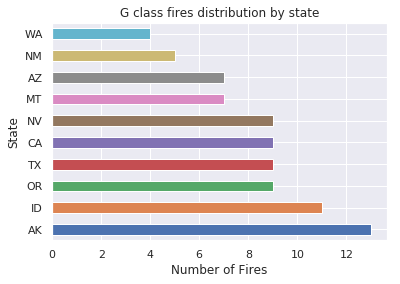

In [51]:
# big fires distribution by state 
G_fires = fires[fires['FIRE_SIZE_CLASS'] == 'G']
G_fires['STATE'].value_counts()[:10].plot(kind='barh')
plt.title('G class fires distribution by state')
plt.ylabel('State')
plt.xlabel('Number of Fires')

Text(0.5,0,'Number of Fires')

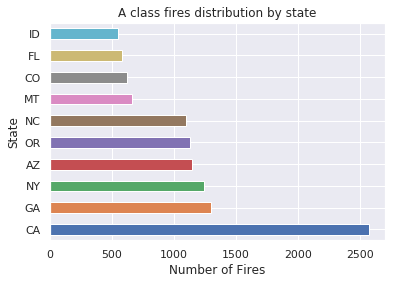

In [52]:
# small fires distribution by state 
A_fires = fires[fires['FIRE_SIZE_CLASS'] == 'A']
A_fires['STATE'].value_counts()[:10].plot(kind='barh')
plt.title('A class fires distribution by state')
plt.ylabel('State')
plt.xlabel('Number of Fires')

In [53]:
cali = fires[fires['STATE'] == 'CA']
cali.pivot_table(values='FOD_ID', index='FIRE_YEAR', columns='FIRE_SIZE_CLASS',
                 aggfunc='count', margins=True)

FIRE_SIZE_CLASS,A,B,C,D,E,F,G,All
FIRE_YEAR,,,,,,,,
1992,164.0,102.0,16.0,3.0,1.0,NaN,1.0,287
1993,107.0,92.0,17.0,8.0,2.0,1.0,NaN,227
1994,105.0,91.0,14.0,1.0,3.0,2.0,NaN,216
1995,92.0,90.0,6.0,3.0,2.0,1.0,1.0,195
1996,109.0,101.0,15.0,5.0,1.0,3.0,NaN,234
1997,94.0,84.0,9.0,3.0,NaN,1.0,NaN,191
1998,103.0,84.0,13.0,2.0,NaN,NaN,NaN,202
1999,121.0,89.0,8.0,1.0,1.0,1.0,NaN,221
2000,120.0,71.0,3.0,NaN,2.0,1.0,NaN,197


Text(0,0.5,'Number of Fires')

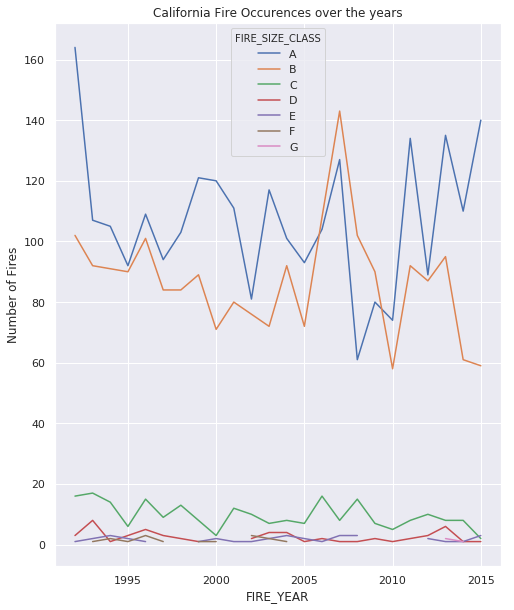

In [54]:
cali.pivot_table(values='FOD_ID', index='FIRE_YEAR', columns='FIRE_SIZE_CLASS',
                 aggfunc='count').plot(figsize=(8, 10))
plt.title('California Fire Occurences over the years')
plt.ylabel('Number of Fires')
# No trend of increase in occurences over the years for CA

<a id="cleanup"></a>
# 4. Clean up


In [55]:
print(len(cols_to_drop))
cols_to_drop

29


['OBJECTID',
 'FPA_ID',
 'SOURCE_SYSTEM_TYPE',
 'SOURCE_SYSTEM',
 'NWCG_REPORTING_AGENCY',
 'NWCG_REPORTING_UNIT_ID',
 'NWCG_REPORTING_UNIT_NAME',
 'SOURCE_REPORTING_UNIT',
 'SOURCE_REPORTING_UNIT_NAME',
 'LOCAL_FIRE_REPORT_ID',
 'LOCAL_INCIDENT_ID',
 'FIRE_CODE',
 'FIRE_NAME',
 'ICS_209_INCIDENT_NUMBER',
 'ICS_209_NAME',
 'MTBS_ID',
 'MTBS_FIRE_NAME',
 'COMPLEX_NAME',
 'OWNER_CODE',
 'OWNER_DESCR',
 'Shape',
 'CONT_DATE',
 'CONT_DOY',
 'CONT_TIME',
 'days_to_contain',
 'DISCOVERY_TIME',
 'DISCOVERY_DOY',
 'STAT_CAUSE_CODE',
 'STAT_CAUSE_DESCR']

In [56]:
lean_fires = fires.drop(cols_to_drop, axis=1)
print(lean_fires.shape)
lean_fires.columns

(50000, 13)


Index(['FOD_ID', 'FIRE_YEAR', 'DISCOVERY_DATE', 'FIRE_SIZE', 'FIRE_SIZE_CLASS',
       'LATITUDE', 'LONGITUDE', 'STATE', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME',
       'hr', 'Cause'],
      dtype='object')

In [61]:
lean_fires.to_pickle('lean_fires.pkl')

<a id="next_steps"></a>
# 5. Next Steps


1. Fill in County information
2. Add some date features


# Old 

In [57]:
# # keeping only the columns that are known at time of discovery or are potentially useful 
# sfires = fires[['FOD_ID', 'SOURCE_SYSTEM_TYPE', 'NWCG_REPORTING_AGENCY', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
#        'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
#        'LONGITUDE', 'STATE', 'COUNTY']]


In [58]:
# sfires.shape

In [59]:
# # Pickled "useful cols" for next notebook
# with open('useful_fires_cols.pkl', 'wb') as picklefile:
#     pickle.dump(sfires, picklefile)

In [60]:
# # test date conversion
# dates = fires['DISCOVERY_DATE'][:5]
# greg_dates = pd.to_datetime(dates, unit='D', origin='julian') #julian dates
# months = greg_dates.dt.month
# months